In [13]:
import pytorch_lightning as pl
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18, resnet34, resnet50
import torch.nn.functional as F
import torchmetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        CIFAR10(root="data", train=True, download=True)
        CIFAR10(root="data", train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            cifar_full = CIFAR10(root="data", train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])
        if stage == 'test' or stage is None:
            self.cifar_test = CIFAR10(root="data", train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=self.batch_size)

In [3]:
class LitResNet(pl.LightningModule):
    def __init__(self, model_type):
        super().__init__()
        if model_type == 'resnet18':
            self.model = resnet18(pretrained=True)
        elif model_type == 'resnet34':
            self.model = resnet34(pretrained=True)
        elif model_type == 'resnet50':
            self.model = resnet50(pretrained=True)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 10)
        
        self.acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=10)
        self.recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=10)
        self.f1 = torchmetrics.F1Score(task="multiclass", average='macro', num_classes=10)


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.acc(y_hat, y))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc', self.acc(y_hat, y))
        self.log('precision', self.precision(y_hat, y))
        self.log('recall', self.recall(y_hat, y))
        self.log('f1_score', self.f1(y_hat, y))
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)

In [5]:
data_module = CIFAR10DataModule()

for model_type in ['resnet18', 'resnet34', 'resnet50']:
    model = LitResNet(model_type)
    trainer = pl.Trainer(max_epochs=15)
    trainer.fit(model, data_module)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


Missing logger folder: /data/home/dimitriishh/workspace/repos/cv_talenthub/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name      | Type                | Params
--------------------------------------------------
0 | model     | ResNet              | 11.2 M
1 | acc       | MulticlassAccuracy  | 0     
2 | precision | MulticlassPrecision | 0     
3 | recall    | MulticlassRecall    | 0     
4 | f1        | MulticlassF1Score   | 0     
--------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |                                                                                | 0/? [00:00…

/data/home/dimitriishh/workspace/envs/base_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/data/home/dimitriishh/workspace/envs/base_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=15` reached.
/data/home/dimitriishh/workspace/envs/base_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/home/dimitriishh/workspace/envs/base_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. 

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name      | Type                | Params
--------------------------------------------------
0 | model     | ResNet              | 21.3 M
1 | acc       | MulticlassAccuracy  | 0     
2 | precision | MulticlassPrecision | 0     
3 | recall    | MulticlassRecall    | 0     
4 | f1        | MulticlassF1Score   | 0     
--------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=15` reached.
/data/home/dimitriishh/workspace/envs/base_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name      | Type                | Params
--------------------------------------------------
0 | model     | ResNet              | 23.5 M
1 | acc       | MulticlassAccuracy  | 0     
2 | precision | MulticlassPrecision | 0     
3 | recall    | MulticlassRecall    | 0     
4 | f1        | MulticlassF1Score   | 0     
--------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=15` reached.


In [72]:
checkpoint = "./lightning_logs/version_2/checkpoints/epoch=14-step=21105.ckpt"
model = LitResNet.load_from_checkpoint(checkpoint, model_type='resnet50')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [73]:
mapping = {0: 'airplanes',
 1: 'cars',
 2: 'birds',
 3: 'cats',
 4: 'deer',
 5: 'dogs',
 6: 'frogs',
 7: 'horses',
 8: 'ships',
 9: 'trucks'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


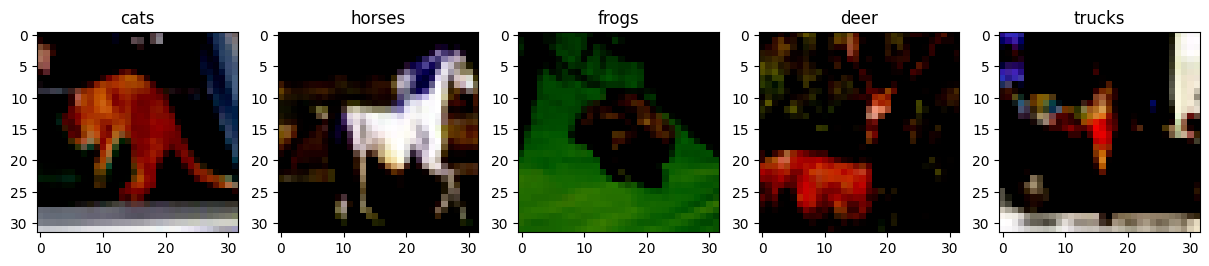

In [74]:
with torch.no_grad():
    for data, _ in data_module.val_dataloader():
        data = data.to(device)
        preds = model(data)
        break
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    ax[i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[i].set_title(mapping[torch.argmax(preds[i]).item()])
plt.show()